# Logistic Regression with `tidymodels`

In this tutorial, we will learn about classification and logistic regression with `tidymodels`. We will be using the `heart_disease` dataset to demonstrate concepts in this tutorial.

The `heart_disease` data contains demographics and outcomes of various medical tests for patients in a heart disease study. The variable of interest in this data is `heart_disease` and it indicates whether a patient was diagnosed with heart disease (Yes or No).

The code below will load the required packages and data sets for this tutorial.

In [2]:
install.packages('vip', repos = 'https://mran.microsoft.com/snapshot/2023-01-01/')

Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/vip_0.3.2.tar.gz' ...
	OK [downloaded 2.6 Mb in 0.7 secs]
Installing vip [0.3.2] ...
	OK [installed binary]
Moving vip [0.3.2] into the cache ...
	OK [moved to cache in 0.66 milliseconds]


In [43]:
library(tidymodels)
library(vip)

# Heart disease data
heart_df <- 
  readRDS(url('https://gmubusinessanalytics.netlify.app/data/heart_disease.rds')) %>% 
  # Select a subset of the data
  select(heart_disease, age, chest_pain, max_heart_rate, resting_blood_pressure)

In [45]:
# View data
heart_df

heart_disease,age,chest_pain,max_heart_rate,resting_blood_pressure
<fct>,<int>,<fct>,<int>,<int>
no,63,typical,150,145
yes,67,asymptomatic,108,160
yes,67,asymptomatic,129,120
no,37,non_anginal,187,130
no,41,atypical,172,130
no,56,atypical,178,120
yes,62,asymptomatic,160,140
no,57,asymptomatic,163,120
yes,63,asymptomatic,147,130


# Introduction to Logistic Regression

In logistic regression, we are estimating the probability that our **Bernoulli** response variable is equal to the `Positive` class. 

In classification, the event we are interested in predicting, such as `heart_disease = 'Yes'` in our heart disease example, is known as the `Postive` event. Whereas the remaining event, `heart_disease = 'No'`, is the `Negative` event. 

In our course tutorials, we will follow the model fitting process that is expected to be followed on the course analytics project. When fitting a classification model, whether logistic regression or a different type of algorithm, we will take the following steps:

- Split the data into a training and test set
- Specify a feature engineering pipeline with the `recipes` package
- Specify a `parsnip` model object
- Package your recipe and model into a workflow
- Fit your workflow to the training data
    - If your model has hyperparameters, perform hyperparameter tuning - this will be covered next week
- Evaluate model performance on the test set by studying the confusion matrix, ROC curve, and other performance metrics
<br>

Let's demonstrate this process using logistic regression and the `heart_df` data.

## Data Splitting

The first step in modeling is to split our data into a training and test set. In the classification setting, we must also make sure that the response variable in our data set is a factor. 

By default, `tidymodels` maps the first level of a factor to the `Positive` class while calculating performance metrics. Therefore, before we split our data and proceed to modeling, we need to make sure that the event we are trying to predict is the first level of our response variable.

For the `heart_df` data, the event we are interested in predicting is `heart_disease = 'Yes'`. We can use the `levels()` function to check the current ordering of the levels of the `heart_disease` variable.

In [6]:
levels(heart_df$heart_disease)

[1] "yes" "no"

<br>

Since 'yes' is the first level, we don't need to take an further steps and can proceed to splitting our data. 

In the code below, we use the `initial_split()` function from `rsample` to create our training and testing data using the `heart_df` data.

In [7]:
## Always remember to set your seed
## Add an integer to the argument of set.seed()
set.seed(345)

heart_split <- 
  initial_split(heart_df, prop = 0.75, strata = heart_disease)

heart_training <- 
  heart_split %>% 
  training()

heart_test <- 
  heart_split %>% 
  testing()

## Feature Engineering

The next step in the modeling process is to define our feature engineering steps. In the code below, we process our numeric predictors by removing skewness and normalizing, and create dummy variables from our `chest_pain` predictor. 

When creating a feature engineering pipeline, it's important to exclude `prep()` and `bake()` because these will be implemented automatically in our workflow that is created at a later stage

In [8]:
heart_recipe <-
  recipe(heart_disease ~ ., data = heart_training) %>% 
  step_YeoJohnson(all_numeric(), -all_outcomes()) %>% 
  step_normalize(all_numeric(), -all_outcomes()) %>% 
  step_dummy(all_nominal(), -all_outcomes())

<br>

However, it is always good practice to check that the feature engineering recipe is doing what we expect. The code below processes our training data with `prep()` and `bake()` so that we can have a look at the results.

In [9]:
heart_recipe %>% 
  prep(training = heart_training) %>% 
  bake(new_data = NULL)

age,max_heart_rate,resting_blood_pressure,heart_disease,chest_pain_atypical,chest_pain_non_anginal,chest_pain_asymptomatic
<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
0.90354006,-0.053581285,0.75326453,no,0,0,0
-1.81654210,1.850802966,-0.04045855,no,0,1,0
-1.46149369,1.023216071,-0.04045855,no,1,0,0
0.19219500,0.563117601,-0.66870519,no,0,0,1
0.19219500,-0.143462061,0.50585301,no,0,0,1
0.07833669,0.083732043,0.50585301,no,1,0,0
-0.36340086,0.513674396,1.86116944,no,0,1,0
0.19219500,1.129163112,0.98566295,no,0,1,0
-0.78284043,-0.531533013,-0.04045855,no,0,1,0


## Model Specification

Next, we define our logistic regression model object. In this case, we use the `logistic_reg()` function from `parsnip`. Our engine is `glm` and our mode is `classification`

In [10]:
logistic_model <- 
  logistic_reg() %>% 
  set_engine('glm') %>% 
  set_mode('classification')

## Create a Workflow

Now we can combine our model object and recipe into a single workflow object using the `workflow()` function

In [11]:
heart_wf <-
  workflow() %>% 
  add_model(logistic_model) %>% 
  add_recipe(heart_recipe)

## Fit the Model

Next we fit our workflow to the training data. This is done by passing our workflow object to the `fit()` function

In [12]:
heart_logistic_fit <- 
  heart_wf %>% 
  fit(data = heart_training)

## Exploring our Trained Model

Once we have trained our logistic regression model on our training data, we can optionally study variable importance with the `vip()` function.

The first step is to extract the trained model from our workflow fit, `heart_logistic_fit`. This can be done by passing `heart_logistic_fit` to the `extract_fit_parsnip()` function

In [13]:
heart_trained_model <- 
  heart_logistic_fit %>% 
  extract_fit_parsnip()

## Variable Importance

Next we pass `heart_trained_model` to the `vip()` function. This will return a `ggplot` object with the variable importance scores from our model. The importance scores are based on the z-statistics associated with each predictor. 

We see from the results below, that asymptomatic chest pain, maximum heart rate, and resting blood pressure, are the most important predictors of heart disease from our data set

In [15]:
# This code adjust the figure output size
options(repr.plot.width=11, repr.plot.height=8)

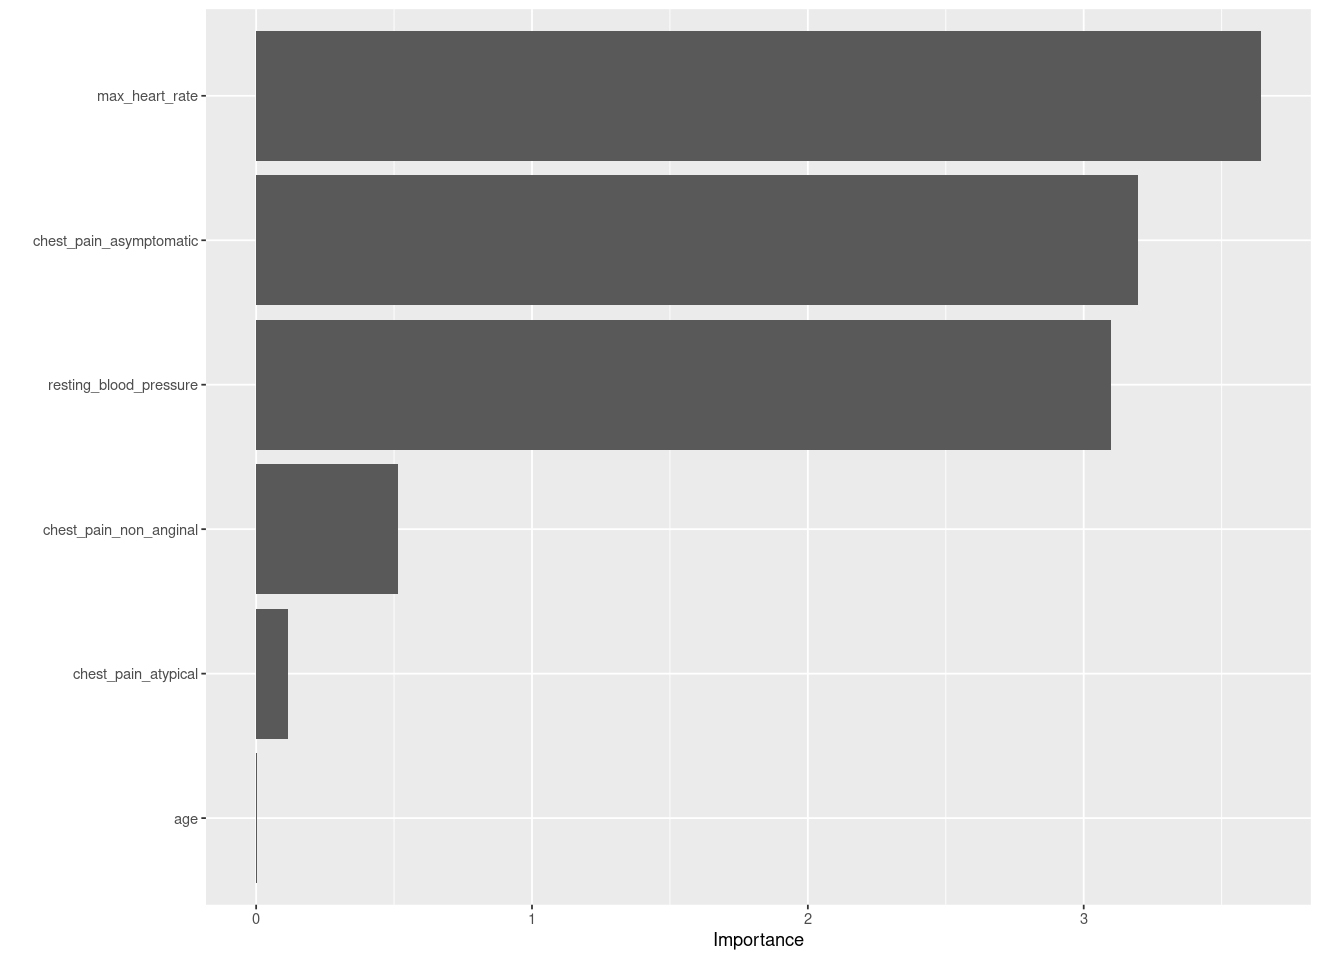

In [16]:
vip(heart_trained_model)

## Evaluate Performance

The next step in the modeling process is to assess the accuracy of our model on new data. This is done by obtaining predictions on our test data set with our trained model object, `heart_logistic_fit`.

Before we can do this, we create a results data frame with the following data:

- The true response values from our test set
- The predicted response category for each row of our test data
- The estimated probabilities for each response category

All of this data can be put together using the `predict()` function

## Predicted Categories

To obtain the predicted category for each row in our test set, we pass the `heart_logistic_fit` object to the `predict` function and specify `new_data = heart_test`.

We will get a data frame with a column named `.pred_class` which has the predicted category (yes/no) for each row of our test data set.

In [17]:
predictions_categories <- 
  predict(heart_logistic_fit, new_data = heart_test)

predictions_categories

.pred_class
<fct>
yes
no
no
no
yes
no
no
yes
yes


<br>

Next we need to obtain the estimated probabilities for each category of our response variable.

This is done with the same code as above but with the additional argument, `type = 'prob'`

In this case we get a data frame with the following columns, `.pred_yes` and `.pred_no`. 

The `tidymodels` package will always use the following convention for naming these columns `.pred_level_of_factor_in_response_variable`

In [18]:
predictions_probabilities <- 
  predict(heart_logistic_fit, new_data = heart_test, type = 'prob')

predictions_probabilities

.pred_yes,.pred_no
<dbl>,<dbl>
0.75442552,0.24557448
0.07209693,0.92790307
0.24475080,0.75524920
0.08679018,0.91320982
0.69148587,0.30851413
0.12924251,0.87075749
0.07791785,0.92208215
0.52883764,0.47116236
0.79765328,0.20234672


<br>

The final step is to combine the results from above with the true response variable values in our test data set

In [19]:
# Combine
test_results <- 
  heart_test %>% 
  select(heart_disease) %>% 
  bind_cols(predictions_categories) %>% 
  bind_cols(predictions_probabilities)

test_results

heart_disease,.pred_class,.pred_yes,.pred_no
<fct>,<fct>,<dbl>,<dbl>
yes,yes,0.75442552,0.24557448
no,no,0.07209693,0.92790307
yes,no,0.24475080,0.75524920
no,no,0.08679018,0.91320982
no,yes,0.69148587,0.30851413
no,no,0.12924251,0.87075749
no,no,0.07791785,0.92208215
no,yes,0.52883764,0.47116236
yes,yes,0.79765328,0.20234672


## Exploring Performance Metrics

The `yardstick` package from `tidymodels` has a number of functions for calculating performance metrics on the results of a machine learning algorithm. 

Important functions from this package include `conf_mat()`, `sens()`, `spec()`, `roc_curve()`, and `roc_auc()`

All of these functions take a data frame with the structure of our `test_results` as the first argument. The input data frame must contain the three pieces of information mentioned at the beginning of this section:

- The true response values from our test set
- The predicted response category for each row of our test data
- The estimated probabilities for each response category

## Confusion Matrix

<p align="center">
<img 
  src="./files/confusion_matrix.png"
  width="400"
  height="auto"
/>
</p>

The first result to explore is usually the confusion matrix. The `conf_mat()` function will produce one for us. It takes the following important arguments:

- `data` - the first argument is a data frame with model results (usually on the test set)
- `truth` - a factor column with the true response categories
- `estimate` - a factor column with the predicted response categories

The results of this function are a confusion matrix with the predicted categories in the rows and true categories in the columns. 

By default, all `yardstick` functions map the first level of the response variable to the positive class. The `conf_mat()` function orders the output by displaying the positive class first in both the rows and columns.

Form the results below, we have 58 correct predictions on our test data set. Since we have 76 rows in our test data, this gives us an accuracy of 76%.

We have 7 false positives (we predicted the positive class ('yes') but the truth was 'no') and 11 false negatives.

In [20]:
conf_mat(test_results, 
         truth = heart_disease, 
         estimate = .pred_class)

          Truth
Prediction yes no
       yes  24  7
       no   11 34

## Sensitivity (Recall)

<p align="center">
<img 
  src="./files/sensitivity.png"
  width="400"
  height="auto"
/>
</p>

The sensitivity is a performance metric that calculates the proportion of actual positive cases that the classification model predicted correctly. 

In our heart disease example, this is the proportion of patients who developed heart disease (`heart_disease` = Yes) that were predicted to develop heart disease.

The `sens()` function from `yardstick` is used to calculate this metric. It takes the same arguments as `conf_mat()`.

From the results below, we have a sensitivity of 0.69 on our test data results.

In [21]:
sens(test_results,
     truth = heart_disease, 
     estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
sens,binary,0.6857143


## Specificity

<p align="center">
<img 
  src="./files/specificity.png"
  width="400"
  height="auto"
/>
</p>

The specificity is a performance metric that calculates the proportion of actual negative cases that the classification model predicted correctly. 

In our heart disease example, this is the proportion of patients who did not develop heart disease (`heart_disease` = No) that were predicted to not develop heart disease.

The `spec()` function from `yardstick` is used to calculate this metric. It takes the same arguments as `conf_mat()`.

From the results below, we have a sensitivity of 0.83 on our test data results.

In [22]:
spec(test_results,
     truth = heart_disease, 
     estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
spec,binary,0.8292683


## ROC Curve

<p align="center">
<img 
  src="./files/roc_curve.png"
  width="400"
  height="auto"
/>
</p>

The ROC curve is a way to visualize the performance of any classification model. The plot includes the [sensitivity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) on the y-axis and (1 - [specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity)) on the x-axis for all possible probability cut-off values. 

The default probability cut-off value used by classification models is 0.5. But changing this can guard against either false positives or false negatives. The ROC curve plots all of this information in one plot.

**What to look for**: the best ROC curve is as close as possible to the point (0, 1) that is at the top left corner of the plot. The closer the ROC curve is to that point throughout the entire range, the better the classification model. 

The dashed line through the middle of the graph represents a model that is just guessing at random.

The first step in creating an ROC curve is to pass our results data frame to the `roc_curve()` function. This function takes a data frame with model results, the `truth`, and `estimate` columns to produce a data frame with the specificity and sensitivity for all probability thresholds.

In [23]:
roc_curve(test_results, 
          truth = heart_disease,
          estimate = .pred_yes)

.threshold,specificity,sensitivity
<dbl>,<dbl>,<dbl>
-Inf,0.00000000,1.0000000
0.04013921,0.00000000,1.0000000
0.04817757,0.02439024,1.0000000
0.05581659,0.04878049,1.0000000
0.06187706,0.07317073,1.0000000
0.06682689,0.09756098,1.0000000
0.06739724,0.09756098,0.9714286
0.07157006,0.09756098,0.9428571
0.07209693,0.12195122,0.9428571


<br>

To plot this data, we simply pass the results of `roc_curve()` to the `autoplot()` function

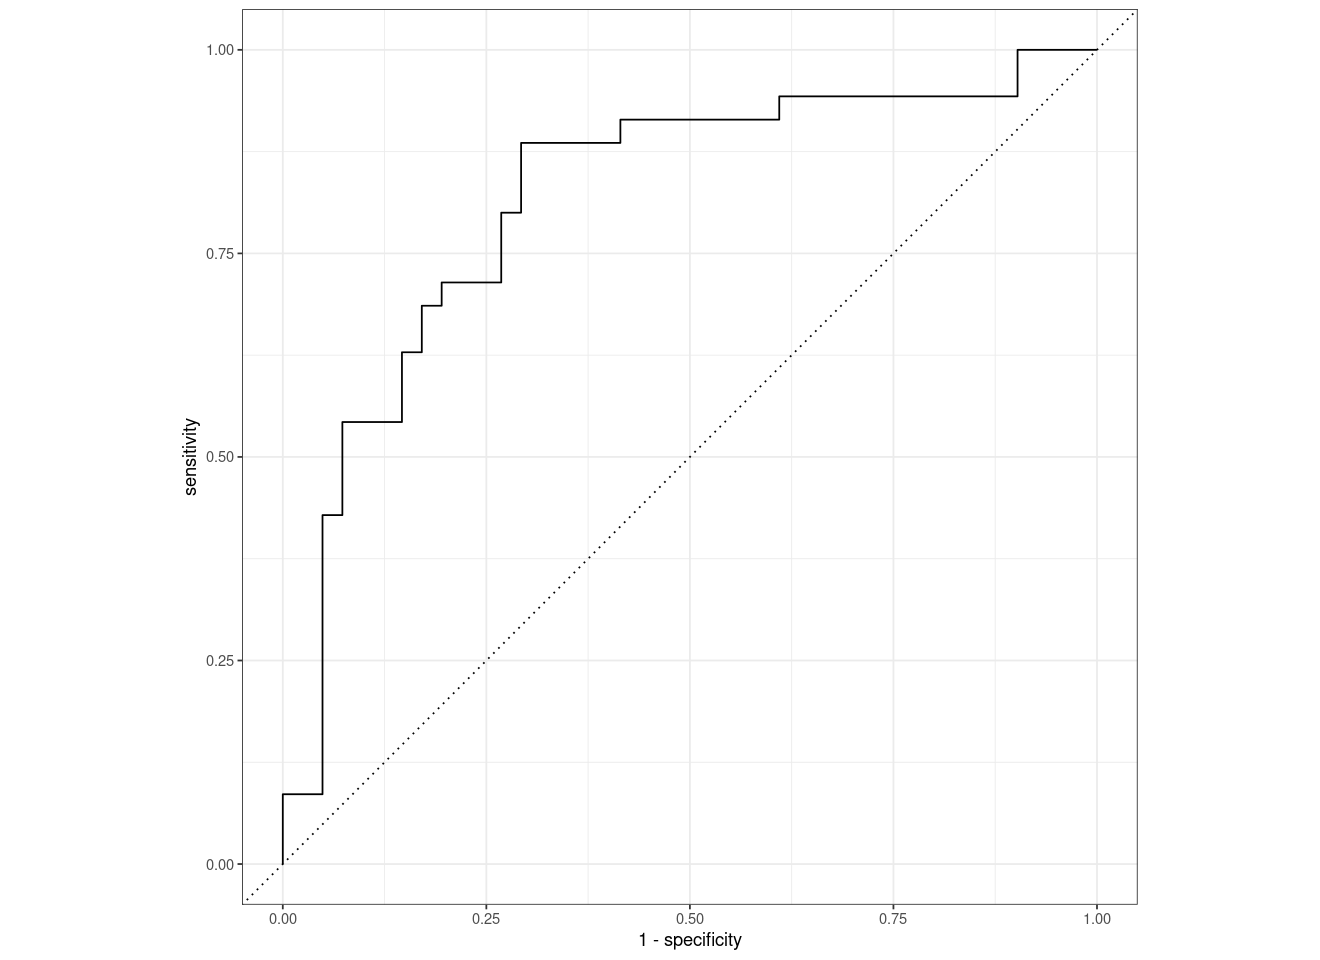

In [24]:
roc_curve(test_results, 
          truth = heart_disease, 
          estimate = .pred_yes) %>% 
  autoplot()

## Area Under the ROC Curve

<p align="center">
<img 
  src="./files/roc_auc.png"
  width="400"
  height="auto"
/>
</p>

Another important performance metric is the area under the ROC curve. This metric can be loosely interpreted as a letter grade.

In terms of model performance, an area under the ROC value between 0.9 - 1 indicates an "A", 0.8 - 0.9 a "B", and so forth. Anything below a 0.6 is an "F" and indicates poor model performance.

To calculate the area under the ROC curve, we use the `roc_auc()`.

This function takes the results data frame as the first argument, the `truth` column as the second argument, and the column of estimated probabilities for the positive class as the third argument.

From our results below, our model gets a "B-"

In [25]:
roc_auc(test_results,
        truth = heart_disease, 
        estimate = .pred_yes)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.8181185


## F<sub>1</sub> Score

<p align="center">
<img 
  src="./files/f1_score.png"
  width="450"
  height="auto"
/>
</p>

The F<sub>1</sub> score is a performance metric that equally balances our false positive and false negative mistakes by combining sensitiviy (recall) and precision into a single number.

The range of an F<sub>1</sub> score is from 0 (worst) to 1 (best).

The `f_meas()` function from `yardstick` is used to calculate this metric. It takes the same arguments as `conf_mat()`.

From the results below, we have an F<sub>1</sub> score 0.73 on our test data results

In [26]:
f_meas(test_results,
       truth = heart_disease, 
       estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
f_meas,binary,0.7272727


## Creating Custom Metric Sets

It is also possible to create a custom metric set using the `metric_set()` function. This function takes `yardstick` function names as arguments and returns a new function that we can use to calculate that set of metrics.

In the code below we create a new function, `my_metrics()` that will calculate the accuracy, sensitivity, specificity,  F<sub>1</sub>, and ROC AUC from the results data frame.

**Note**: Since `accuracy()`, `sens()`, `spec()`, and `f_meas()` require the `truth` and `estimate` columns while `roc_auc()` requires the `truth` column and a column of estimated probabilities for the positive class, all three must be provided to the custom function when it is called

In [27]:
my_metrics <- metric_set(accuracy, sens, spec, f_meas, roc_auc)

my_metrics(test_results, 
           truth = heart_disease, 
           estimate = .pred_class,
           .pred_yes)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7631579
sens,binary,0.6857143
spec,binary,0.8292683
f_meas,binary,0.7272727
roc_auc,binary,0.8181185


## Automating the Process

Just like with linear regression, we can automate the process of fitting a logistic regression model by using the `last_fit()` function. This will automatically give use the predictions and metrics on our test data set.

In the example below, we will fit the same model as above, but with `last_fit()` instead of `fit()`.

The `last_fit()` function takes a workflow object as the first argument and a data split object as the second. It will train the model on the training data and provide predictions and calculate metrics on the test set.

The `last_fit()` function takes an optional `metrics` argument where a custom metric function can be provided. In the example below, we use our `my_metrics()` function. If this is left out of the call to `last_fit()`, it will calculate accuracy and ROC AUC by default

In [28]:
last_fit_model <- 
  heart_wf %>% 
  last_fit(split = heart_split,
           metrics = my_metrics)

<br>

To obtain the metrics on the test set (accuracy and roc_auc by default) we use `collect_metrics()`

In [29]:
last_fit_model %>% 
  collect_metrics()

.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
accuracy,binary,0.7631579,Preprocessor1_Model1
sens,binary,0.6857143,Preprocessor1_Model1
spec,binary,0.8292683,Preprocessor1_Model1
f_meas,binary,0.7272727,Preprocessor1_Model1
roc_auc,binary,0.8181185,Preprocessor1_Model1


<br>

We can also obtain a data frame with test set results by using the `collect_predictions()` function

In [30]:
last_fit_results <- 
  last_fit_model %>% 
  collect_predictions()

last_fit_results

id,.pred_class,.row,.pred_yes,.pred_no,heart_disease,.config
<chr>,<fct>,<int>,<dbl>,<dbl>,<fct>,<chr>
train/test split,yes,3,0.75442552,0.24557448,yes,Preprocessor1_Model1
train/test split,no,6,0.07209693,0.92790307,no,Preprocessor1_Model1
train/test split,no,13,0.24475080,0.75524920,yes,Preprocessor1_Model1
train/test split,no,14,0.08679018,0.91320982,no,Preprocessor1_Model1
train/test split,yes,18,0.69148587,0.30851413,no,Preprocessor1_Model1
train/test split,no,20,0.12924251,0.87075749,no,Preprocessor1_Model1
train/test split,no,35,0.07791785,0.92208215,no,Preprocessor1_Model1
train/test split,yes,36,0.52883764,0.47116236,no,Preprocessor1_Model1
train/test split,yes,37,0.79765328,0.20234672,yes,Preprocessor1_Model1


<br>

We can use this data frame to make an ROC plot by using `roc_curve()` and `autoplot()`

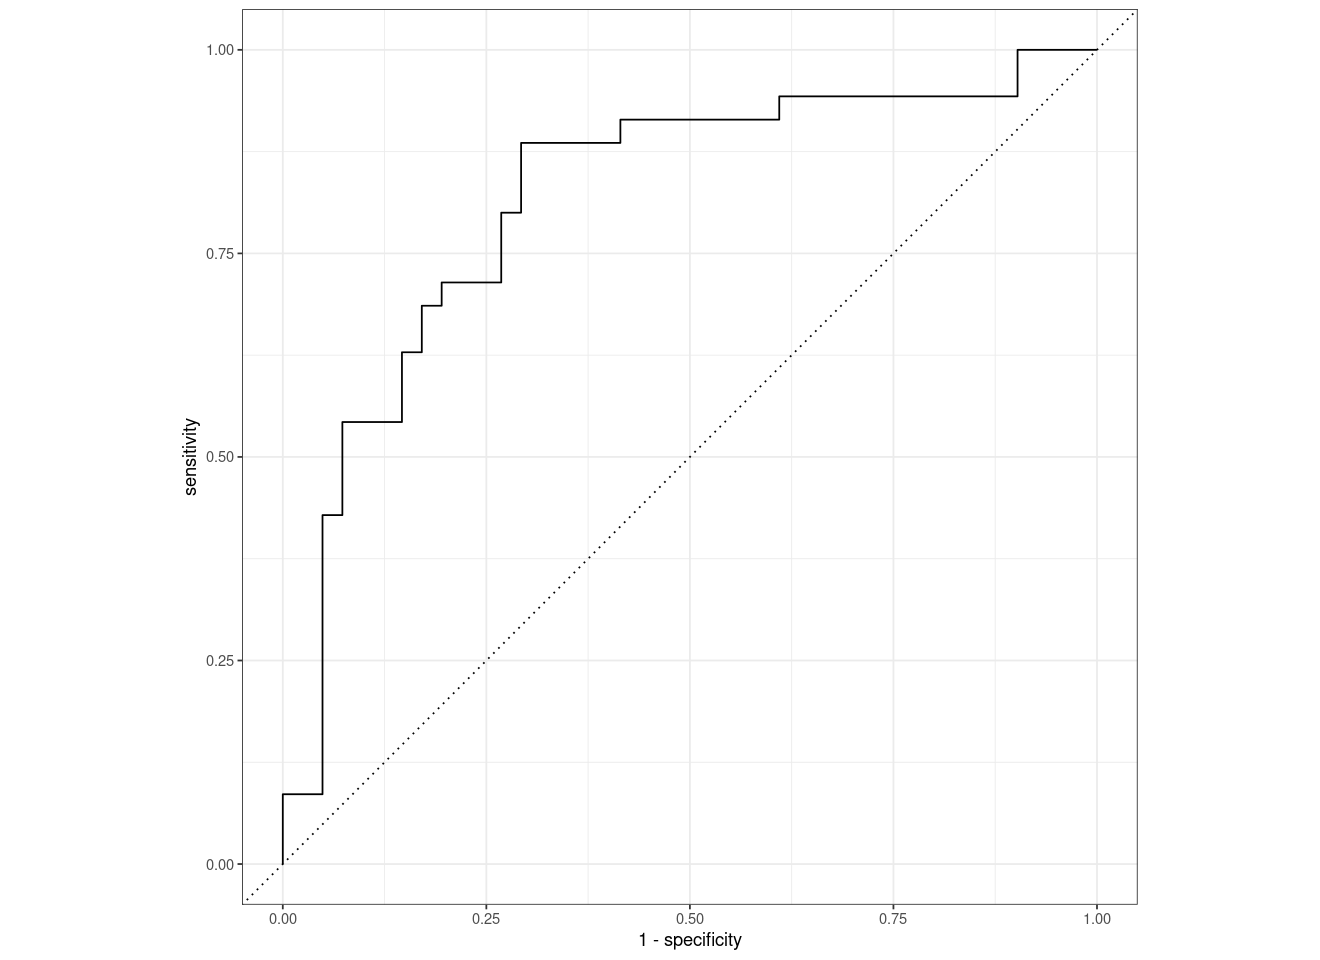

In [31]:
last_fit_results %>% 
  roc_curve(truth = heart_disease, estimate = .pred_yes) %>% 
  autoplot()